# COMP 551 - Mini-project 3
Group 63

In [2]:
import keras
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns
import os

np.random.seed(1234)

## Task 1. Data pre-processing

- Load the raw data from Keras.
- Vectorize 28*28 pictures to 1D vector.
- Normalize the intensity of the pixel.

Load the MNIST dataset distributed with Keras. 

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


Vectorize the 28*28 pictures to a 784 vector.

In [4]:
x_train = np.reshape(x_train, (-1, 784)).astype('float32')
x_test = np.reshape(x_test, (-1, 784)).astype('float32')
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


The intensity ranges from 0 to 255. We divide all intensities by the maximum (255) to obtain a [0-1] range.

In [5]:
print('Intensity before normalization:', np.amin(x_train), np.amax(x_train))
x_train, x_test = x_train/255.0, x_test/255.0
print('Intensity after normalization:', np.amin(x_train), np.amax(x_train))

Intensity before normalization: 0.0 255.0
Intensity after normalization: 0.0 1.0


We transform the (N,) vector of labels using one-hot encoding into a (N,C) matrix.

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [7]:
print(y_train.shape, y_test.shape)
print(y_train[0:3,])

(60000, 10) (10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Subset the data to use in Colab.

In [7]:
""""data_slice = 3000
x_train = x_train[:data_slice,:]
y_train = y_train[:data_slice,:]
x_test = x_test[:data_slice,:]
y_test = y_test[:data_slice,:]"""

'"data_slice = 3000\nx_train = x_train[:data_slice,:]\ny_train = y_train[:data_slice,:]\nx_test = x_test[:data_slice,:]\ny_test = y_test[:data_slice,:]'

## Task 2. Multilayer perceptron implementation

### 2.1 Build the network
Our task is a multiclass classification.The cost function will be the multi-class cross-entropy loss. We will use the following architecture:
- output layer = softmax activation
- hidden layers (0, 1 or 2): 128 units, ReLu, tanh or logistic activation


First, we implement the activation functions.

In [8]:
# logistic/sigmoid
logistic = lambda z: 1./ (1 + np.exp(-z))

# softmax
eps=1e-8
def softmax(z):
    logits = z - np.max(z) # for numerical stability
    sum_logits = np.sum(np.exp(logits), axis=1) +eps
    softmax = np.exp(logits)/sum_logits[:,None] 
    return softmax

#defining the tanh activation function
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return 1 - (output ** 2)

Next, we build the MLP class.

In [9]:
# for 2 hidden layer with tanh activation function
class MLP2layer_tanh:
    
    def __init__(self, M = 128):
        self.M = M
            
    def fit(self, x_train, y_train, x_test, y_test, optimizer):
        N = x_train.shape[0]
        C = y_train.shape[1] # number of classes
        D = x_train.shape[1]
        def gradient(x, y, params):
            v, w, u = params
            # forward pass
            n = x.shape[0]
            # add bias to the input layer
            x = np.column_stack([x,np.ones(n)*0.1])
            b = np.ones((n,1))*0.1

            q1 = np.dot(x, v) #np.column_stack([np.dot(x, v),np.ones(N)*0.1]) #trying adding bias here
            z1 = tanh(np.hstack((q1,b))) #N x M want to column stack to add bias here
            q2 = np.dot(z1,w) #np.column_stack([np.dot(z1,w),np.ones(N)*0.1]) #trying adding bias here
            z2 = tanh(np.hstack((q2,b)))
            yh = softmax(np.dot(z2, u))#N x C
            # backward pass => gradient formula adapted from class dw = (yh-y)*z, dv = (yh-y)*w*tanh2deriv(q)*x
            
            dy = yh - y #N x C
            
            du = np.dot(z2.T,dy)/N
            
            #print(dz2.shape)  
            dz2 = np.dot(dy,u.T)
            dz2 = np.delete(dz2, -1, axis=1)
            dq2 = tanh2deriv(q2)
            #print(dz2.T * dq2)
            dw = np.dot(z1.T, dz2 * dq2)/N #M x C
            dz1 = np.dot(dz2, w.T) #N x M
            dz1 = np.delete(dz1,-1,axis=1)
            dq1 = tanh2deriv(q1)
            dv = np.dot(x.T, dz1 * dq1)/N #D x M
            dparams = [dv, dw, du]
            return dparams
        
        # initialize the parameters with values in the standard normal distribution and scaled to be low
        u = np.random.randn(self.M+1,C) * 0.1 #M x C
        w = np.random.randn(self.M+1,self.M) * .01 #M x M
        v = np.random.randn(D+1,self.M) * .01 #D x M
        
        params0 = [v,w,u]

        # run the mini-batch gradient descent to update the parameters
        self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x_train, y_train, x_test, y_test, params0)
        return self
    
    def predict(self, x):
        v, w, u = self.params
        # add bias to the input layer
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)*0.1])
        b1 = np.ones((Nt,1))*0.1
     
        # forward pass only using updated parameters

        q1 = np.dot(x,v)
        z1 = tanh(np.hstack((q1,b1)))
        q2 = np.dot(z1,w)
        z2 = tanh(np.hstack((q2,b1)))
        yh = softmax(np.dot(z2, u))#N x C
        return yh

### 2.2 Implement the cost and accuracy function



In [10]:
# Softmax cross entropy 
def logsumexp(Z):                                                # dimension N x C
    Zmax = np.max(Z,axis=1)[:,None]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))
    return log_sum_exp

# cost for tanh activation - two layers
def cost_tanh(x, y, params):
  Nt = x.shape[0]
  v, w, u = params
  b1 = np.ones((Nt,1))*0.1
  xb = np.column_stack([x,np.ones(Nt)*0.1])
  q1 = np.dot(xb, v) 
  z1 = tanh(np.hstack((q1,b1))) 
  q2 = np.dot(z1,w)
  z2 = tanh(np.hstack((q2,b1)))
  q3 = np.dot(z2, u) #N x C
  nll = - np.mean(np.sum(q3*y, 1) - logsumexp(q3)) 
  return nll

# Accuracy
def evaluate_acc(y, yh):
  y_pred = np.argmax(yh,axis=1)
  accuracy = np.count_nonzero(y_pred == np.argmax(y,axis=1))/y.shape[0]
  return accuracy

### 2.3 Implement the optimizer

We will use a mini-batch gradient-descent algorithm.

In [11]:
def create_mini_batch(x, y, batch_size): 
    D = x.shape[1]
    data = np.hstack((x, y))
    np.random.shuffle(data)
    mini = data[:batch_size,:]                                                    
    x_mini = mini[:,:D]
    y_mini = mini[:,D:]
    return x_mini, y_mini

In [12]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, epsilon=1e-8, batch_size=100, iters=600, epochs=50):
        self.learning_rate = learning_rate
        self.iters = iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epochs = epochs
        
    def run(self, gradient_fn, x_train, y_train, x_test, y_test, params):
        epoch = 1
        train_losses = []
        test_losses = []
        for epoch in range(self.epochs):
          train_epoch_loss = []
          test_epoch_loss = []
          for t in range(self.iters):
            x_mini, y_mini = create_mini_batch(x_train, y_train, self.batch_size)
            train_loss = cost_tanh(x_mini, y_mini, params)
            test_loss = cost_tanh(x_test, y_test, params)
            grad = gradient_fn(x_mini, y_mini, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            if t % self.iters == 0:
              print(f"Epoch: {epoch+1}, Train error: {train_loss:.4f}, Test error: {test_loss:.4f}")
              epoch += 1
            train_epoch_loss.append(train_loss)
            test_epoch_loss.append(test_loss)
          train_losses.append(np.mean(train_epoch_loss))
          test_losses.append(np.mean(test_epoch_loss))
        return params, train_losses, test_losses


## Task 3. Run the experiments

Model with 2 hidden layers and tanh activation

Epoch: 1, Train error: 2.3062, Test error: 2.3038
Epoch: 2, Train error: 2.2536, Test error: 2.2479
Epoch: 3, Train error: 2.0965, Test error: 2.0996
Epoch: 4, Train error: 1.7271, Test error: 1.7277
Epoch: 5, Train error: 1.2706, Test error: 1.3015
Epoch: 6, Train error: 1.0443, Test error: 1.0389
Epoch: 7, Train error: 0.7903, Test error: 0.8726
Epoch: 8, Train error: 0.7730, Test error: 0.7571
Epoch: 9, Train error: 0.7712, Test error: 0.6738
Epoch: 10, Train error: 0.5736, Test error: 0.6098
Epoch: 11, Train error: 0.5434, Test error: 0.5605
Epoch: 12, Train error: 0.6325, Test error: 0.5224
Epoch: 13, Train error: 0.4988, Test error: 0.4917
Epoch: 14, Train error: 0.3989, Test error: 0.4672
Epoch: 15, Train error: 0.4608, Test error: 0.4464
Epoch: 16, Train error: 0.4310, Test error: 0.4291
Epoch: 17, Train error: 0.3276, Test error: 0.4144
Epoch: 18, Train error: 0.4191, Test error: 0.4014
Epoch: 19, Train error: 0.4180, Test error: 0.3907
Epoch: 20, Train error: 0.3590, Test err

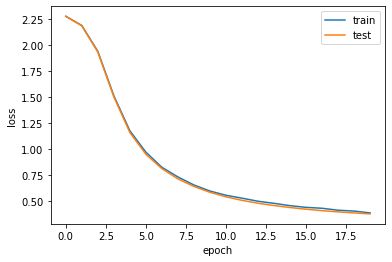

In [13]:
model = MLP2layer_tanh()
optimizer = GradientDescent(learning_rate=2, epochs=20)

model.fit(x_train, y_train, x_test, y_test, optimizer)

plt.plot(np.arange(len(model.train_loss)), model.train_loss, '-', label='train')
plt.plot(np.arange(len(model.test_loss)), model.test_loss, '-', label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
yh = model.predict(x_test) 
accuracy = evaluate_acc(y_test, yh)
print(f'Accuracy is {accuracy*100:.1f}.')

Accuracy is 90.4
